# Argumentation framework

### Unit testing

In [ ]:
from utils.iccma.index import get_graphs
from utils.test.index import test


graphs = get_graphs([
    ("scc", "small"),
    ("gr", "small"),
    ("st", "small"),
])

# Complete, stable and preferred
test(
    graphs=graphs,
    solvers=["manysat", "glucose"],
    semantics=["CO", "ST", "PR"],
    tasks=["SE", "EE"],
    timeout=1,  # seconds
)

# Grounded (must not set the solvers)
test(
    graphs=graphs,
    solvers=[],
    semantics=["GR"],
    tasks=["SE", "EE"],
    timeout=1,  # seconds
)

### Benchmarking

100%          

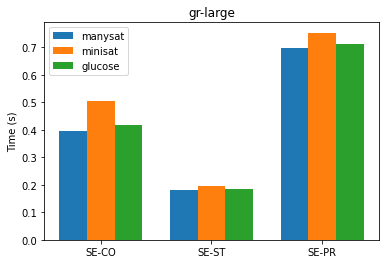

In [4]:
from utils.iccma.index import get_graphs
from utils.benchmark.index import bench

bench(
    graphs=get_graphs([
        ("gr", "large"),
    ]),
    solvers=["manysat", "minisat", "glucose"],
    semantics=["CO", "ST", "PR"],
    tasks=["SE"],
    timeout=5,  # seconds
)

In [ ]:
from utils.iccma.index import get_graphs
from utils.benchmark.index import bench

bench(
    graphs=get_graphs([
        ("gr", "small"),
    ])[:1],
    solvers=["manysat", "minisat", "glucose"],
    semantics=["CO", "ST"],
    tasks=["SE", "EE"],
    timeout=5,  # seconds
)

### Graph generation

In [ ]:
from utils.gen.stable import gen as gen_stable
from utils.gen.grounded import gen as gen_grounded
from utils.gen.scc import gen as gen_scc

g_stable = gen_stable(500, 100, 500, 100, 500, 100, 500, .6)
g_stable.save("stable")

g_grounded = gen_grounded(500, .3)
g_grounded.save("grounded")

# g_scc = gen_scc(500, 500, .6, .3, .4)
# g_scc.save("scc")

### TODO

In [ ]:
# bench(
#     solvers=["manysat", "minisat"],
#     semantics="CO",
#     tasks="SE",
#     graphs=[(a, gen_grounded(a, .3)) for a in range(0, 10)],
#     abs="max arg",
#     ord="time",
# )

# SUPPOSED TO:
# Générer une image d'un graphe pour manysat et un autre pour minisat
# (les deux courbes sur le même graphique)
# avec la sémanntique CO et la tâche SE
# en abscisses: a
# en ordonnées: le temps d'exécution pour résoudre gen_grounded(a, .3)
# du coup il y aurait 10 points par courbe

# AUTRE EXEMPLE
# bench(
#     solvers=["manysat", "minisat"],
#     semantics="CO",
#     tasks="SE",
#     graphs=[(count_arguments(file), file) for file in graph_files],
#     abs="max arg",
#     ord="time",
# )